# Direct Imputation

In [6]:
import numpy as np
import scipy.stats as stats
# import scipy.optimize as opt
# import scipy.io
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

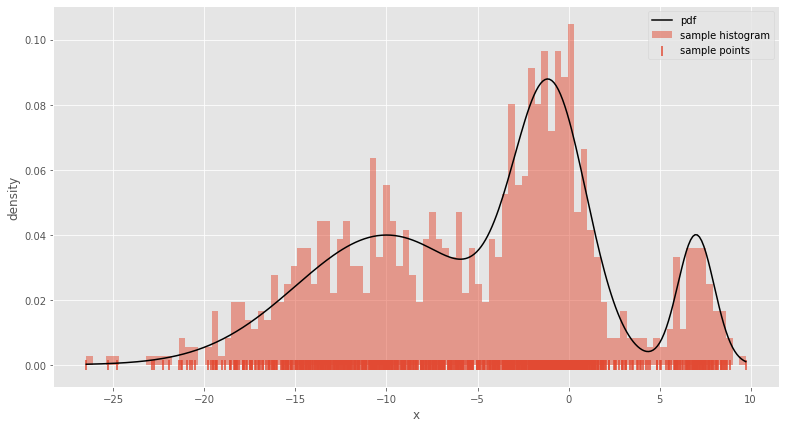

In [2]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Derivative-based imputation

The original paper (*Newey and Powell (1987) Asymmetric Least Squares Estimation and Testing*) introducing expectile regression gives the following theorem:

> **Theorem 1 (iv)** [paraphrased]
> 
> Let $F$ be the continuously differentiable cumulative density function
> of a random variable.
> Let $I_F = \{y | 0 < F(y) < 1\}$.
> Let $\epsilon(\tau)$ be the expectile function (the one minimising the
> asymmetric least squares regression loss).
> 
> * $\epsilon(\tau)$ is continuously differentiable.
>   Let $\epsilon'(\tau)$ be its derivative.
> * Let $\mu$ be the mean of $F$ ($\mu=\epsilon(0.5)$).
>   Then for $y \in I_F$ with $y \neq \mu$, and
>   $\tau(y) \doteq \epsilon^{-1}(y)$,
> 
>     $$F(y)
        =
        -\frac{
            y - \mu + \tau(y) \epsilon'(\tau(y)) (1-2\tau(y))
        }{
            \epsilon'(\tau(y))(1-2\tau(y))^2
        }
      $$

Could we differentiate again to get $f'(y)$, and thus have an approximate imputation procedure given enough expectiles? Or is there not enough information here? What's the catch?

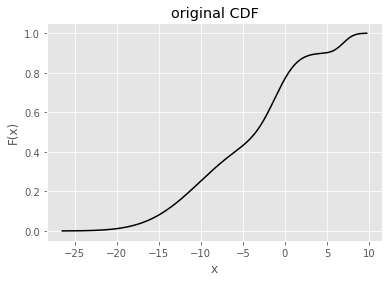

In [3]:
# Plot cumulative distribution function of sample
x = GMM_X
fx = GMM_Y
dx = x[1]-x[0]
Fx = fx.cumsum()*dx
plt.plot(x, Fx, color="black")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.title("original CDF")
plt.show()

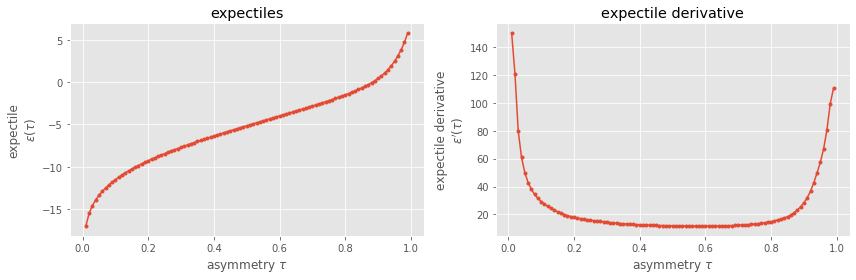

In [4]:
# Plot expectile function and derivative
taus  = np.linspace(0.01, 0.99, 99)
expt  = expectile(SAMPLE, taus)
exptd = np.gradient(expt, taus)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(taus, expt, marker=".")
ax1.set_title("expectiles")
ax1.set_xlabel("asymmetry $\\tau$")
ax1.set_ylabel("expectile\n$\\epsilon(\\tau)$")
ax2.plot(taus, exptd, marker=".")
ax2.set_title("expectile derivative")
ax2.set_xlabel("asymmetry $\\tau$")
ax2.set_ylabel("expectile derivative\n$\\epsilon'(\\tau)$")
plt.tight_layout()
plt.show()

<ipython-input-7-772d54be0c37>:13: RuntimeWarning: divide by zero encountered in true_divide
  Fy = - (y - m + taus[t] * exptd[t] * (1-2*taus[t])) / (exptd[t] * (1-2*taus[t]) ** 2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


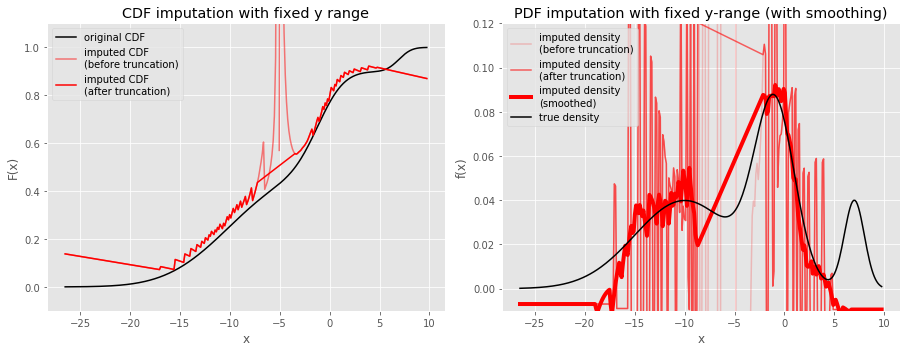

In [7]:
# Try out the formula
#          y - \mu + \tau_y * \epsilon'(\tau_y) * (1-2\tau_y)
# F(y) = - --------------------------------------------------
#                  \epsilon'(\tau_y) * (1-2\tau_y)^2

# use the original sample xs as the ys:
y = GMM_X
m = SAMPLE.mean()
# invert the expectiles function:
t = np.searchsorted(expt[:-1], y)

# compute the CDF
Fy = - (y - m + taus[t] * exptd[t] * (1-2*taus[t])) / (exptd[t] * (1-2*taus[t]) ** 2)

# And the derivative/PDF:
fy = np.gradient(Fy, y)

# try some smoothing
# (NOTE: before or after gradient makes essentially no difference here)
fys = signal.savgol_filter(fy, 31, 2)


# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, alpha=0.5, label="imputed CDF\n(before truncation)", color="red")
# truncate around the mean, where the calculation explodes
_m = np.where(np.abs(taus[t] - 0.5) > 0.15)
ax1.plot(y[_m], Fy[_m], label="imputed CDF\n(after truncation)", color="red")
ax1.set_ylim([-0.1, 1.1])
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.legend()
ax1.set_title("CDF imputation with fixed y range")

ax2.plot(y, fy, alpha=0.2, color="red", label="imputed density\n(before truncation)")
# cut out the near-mean values again
_m = np.where(np.abs(taus[t] - 0.5) > 0.25)
ax2.plot(y[_m], fy[_m], color="red", alpha=0.6, label="imputed density\n(after truncation)")
ax2.plot(y[_m], fys[_m], color="red", linewidth=4, label="imputed density\n(smoothed)")
ax2.plot(x, fx, color="black", label="true density")
ax2.set_ylim([-0.01, 0.12])
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.legend()
ax2.set_title("PDF imputation with fixed y-range (with smoothing)")

plt.tight_layout()
plt.show()

<ipython-input-8-fa4130f71974>:12: RuntimeWarning: divide by zero encountered in true_divide
  Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)


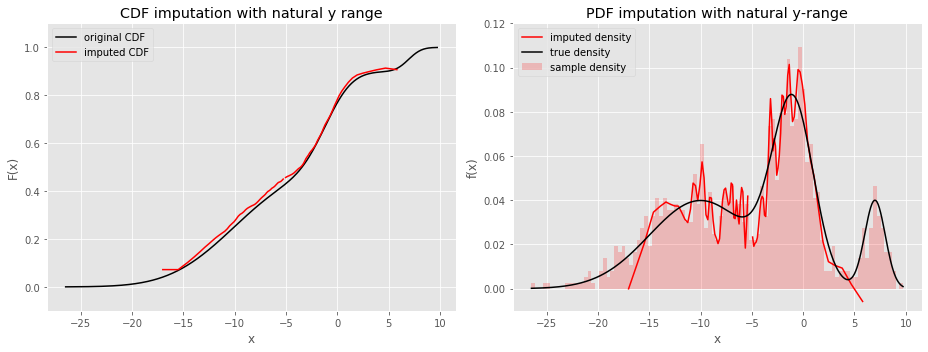

In [8]:
# Given the formula,
#          y - \mu + \tau_y * \epsilon'(\tau_y) * (1-2\tau_y)
# F(y) = - --------------------------------------------------
#                  \epsilon'(\tau_y) * (1-2\tau_y)^2
# and our intention to take derivatives afterwards,
# We should probably use the expectiles as the y values!
# Then there's no need for this 't' inverse step, which was coarse!
# (we can just use the original taus array!)
y = expt
m = SAMPLE.mean()

Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)
fy = np.gradient(Fy, y)

# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.set_title("CDF imputation with natural y range")
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, label="imputed CDF",  color="red")
ax1.set_ylim([-0.1, 1.1])
ax1.legend()

ax2.set_title("PDF imputation with natural y-range")
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.plot(y, fy, label="imputed density", color="red")
ax2.plot(x, fx, label="true density", color="black")
ax2.hist(SAMPLE, density=True, bins=99, label="sample density", color="red", alpha=0.2)
ax2.set_ylim([-0.01, 0.12])
ax2.legend()

plt.tight_layout()
plt.show()

That works so well!

In fact, the spiky-ness is revealed to be recovering the noise in the sample itself! (Matches perfectly with the histogram)

Let's turn it into a function so that we can play with the tau range and density

In [9]:
def direct_impute(taus, epss=None, sample=SAMPLE, x=GMM_X, fx=GMM_Y):
    Fx = fx.cumsum()*(x[1]-x[0])
    # note: remove tau=0.5
    half = np.where(taus == 0.5)
    taus = np.delete(taus, half)
    if epss is not None:
        epss = np.delete(epss, half)
    else:
        epss = expectile(sample, taus)
    
    y = epss
    m = sample.mean()
    
    # epss'
    epssd = np.gradient(epss, taus)
    
    Fy = - (y - m + taus * epssd * (1-2*taus)) / (epssd * (1-2*taus) ** 2)
    fy = np.gradient(Fy, y)
    
    # to remove the noisy-ness we can do some simple fixed-width-bin smoothing
    w = (y[-1]-y[0])/50
    fys = np.zeros_like(fy)
    for i in range(len(y)):
        # TODO: vectorise
        fys[i] = np.mean(fy[np.abs(y - y[i]) < w])

    # plot the resulting imputed functions next to the original functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.set_title("CDF imputation with natural y range")
    ax1.set_xlabel("x")
    ax1.set_ylabel("F(x)")
    ax1.plot(x, Fx, label="original CDF", color="black")
    ax1.plot(y, Fy, label="imputed CDF",  color="red")
    ax1.set_ylim([-0.1, 1.1])
    ax1.legend()

    ax2.set_title("PDF imputation with natural y-range")
    ax2.set_xlabel("x")
    ax2.set_ylabel("f(x)")
    ax2.plot(y, fy, label="imputed density\n(before smoothing)", color="red", alpha=0.5)
    ax2.plot(y, fys,label="imputed density\n(after smoothing)", color="red", linewidth=4)
    ax2.plot(x, fx, label="true density", color="black")
    ax2.set_ylim([-0.01, 0.12])
    ax2.legend()

    plt.tight_layout()
    plt.show()

99 taus


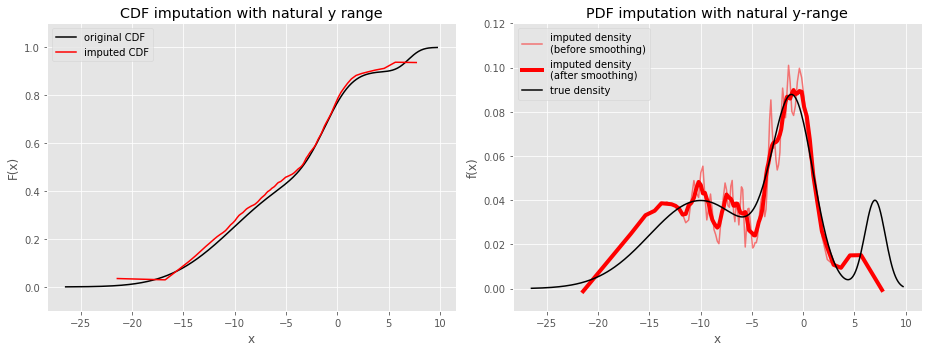

999 taus


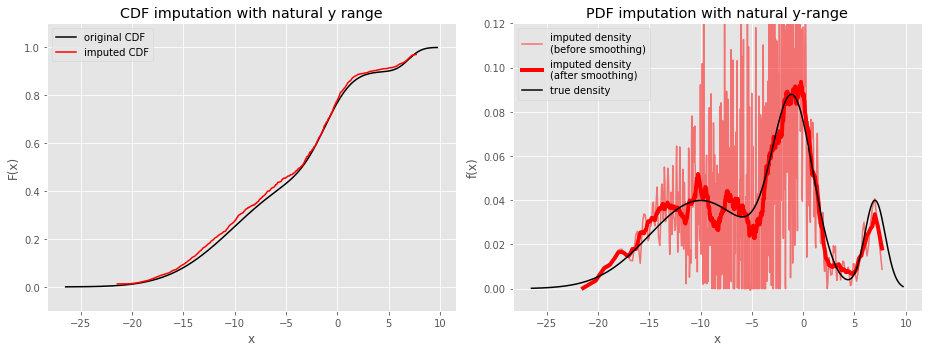

99 low taus


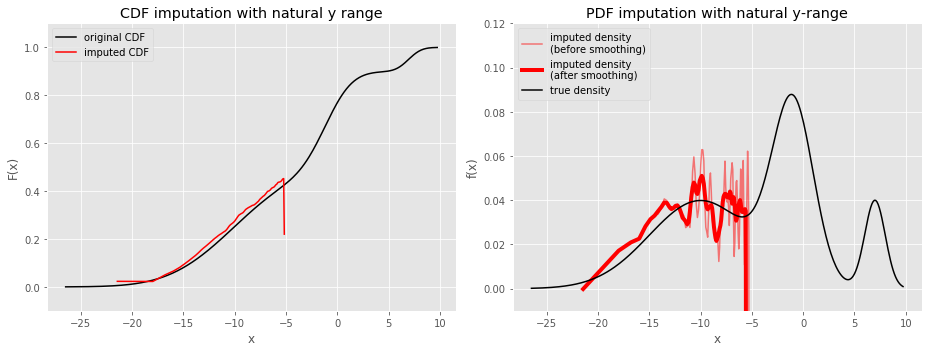

99 high taus


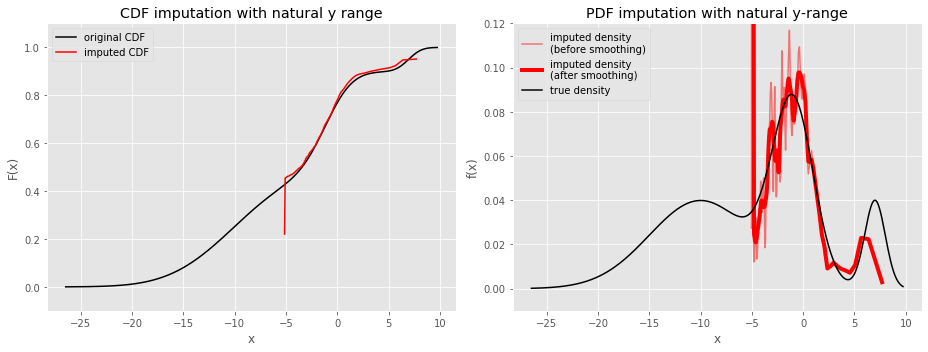

In [10]:
print("99 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 99))
print("999 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 999))
print("99 low taus")
direct_impute(taus=np.linspace(0.001, 0.499, 99))
print("99 high taus")
direct_impute(taus=np.linspace(0.501, 0.999, 99))